In [2]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [3]:
r = readers.CollectionReader('../src/adv_logging/agents')

100%|██████████| 128/128 [00:12<00:00,  9.85it/s]


In [4]:
metadata = r.df('metadata')
opt = r.df('optimization')
opt['opt_step'] = opt.index
nadv = r.df('normalized_advantage')
nadv['opt_step'] = (nadv.index % 50) * 10
constraints = r.df('paper_constraints_train')
constraints_heldout = r.df('paper_constraints_heldout')

In [5]:
metadata['kl_penalty'] = (metadata['kl_penalty_coeff'] > 0)
metadata['clipped_surrogate'] = (metadata['clip_eps'] < 1)
metadata = metadata.drop(columns=['kl_penalty_coeff', 'clip_eps'])

In [6]:
games =  ["Walker2d-v2", "Humanoid-v2", "Swimmer-v2", "Hopper-v2",
          "HalfCheetah-v2", "InvertedPendulum-v2", "Reacher-v2", "InvertedDoublePendulum-v2"]
code_level_opts = {
      #'clip_eps': [0.2, 1e8],
      'clipped_surrogate': [True, False],
      'kl_penalty': [True, False],
      #'kl_penalty_coeff': [3, 0.0],
      #'kl_penalty_direction': ['new_to_old', 'old_to_new'],
      #'clip_advantages': [3, 5, 1e8],
      'norm_rewards': ['none', 'returns'],
      #'anneal_lr': [False, True],
      #'value_clipping': [False, True],
      #'initialization': ['xavier', 'orthogonal']
}

NUM_BINS = 20

In [7]:
key_metadata = metadata[['exp_id', 'game'] + list(code_level_opts.keys())]
constraints = constraints.merge(key_metadata, on='exp_id')
constraints_heldout = constraints_heldout.merge(key_metadata, on='exp_id')
nadv = nadv.merge(key_metadata, on='exp_id')
opt = opt.merge(key_metadata, on='exp_id')

In [8]:
nadv_metrics = ['skewness', 'max', 'kurtosis', 'min']

# KL distribution and how KL changes over training

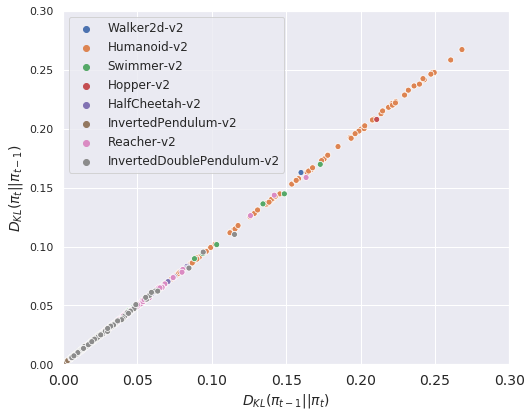

In [112]:
fig = plt.figure(figsize=(8, 6.5))
ax = sns.scatterplot(x='avg_kl_old_to_new', y='avg_kl_new_to_old',
                     data=constraints_heldout[
                         (constraints_heldout.clipped_surrogate == True) & (
                             constraints_heldout.kl_penalty == False) & (
                             constraints_heldout.norm_rewards == 'returns')],
                     hue='game')
ax.set_xlabel(r'$D_{KL}(\pi_{t-1} || \pi_t)$', fontname='sans-serif', fontsize=14)
ax.set_ylabel(r'$D_{KL}(\pi_t || \pi_{t-1})$', fontname='sans-serif', fontsize=14)
ax.legend().remove()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
#plt.legend(ncol=1, loc='upper left')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:], loc='upper left', ncol=1, fontsize=12)
ax.set_ylim([0,0.3])
ax.set_xlim([0,0.3])
plt.show()

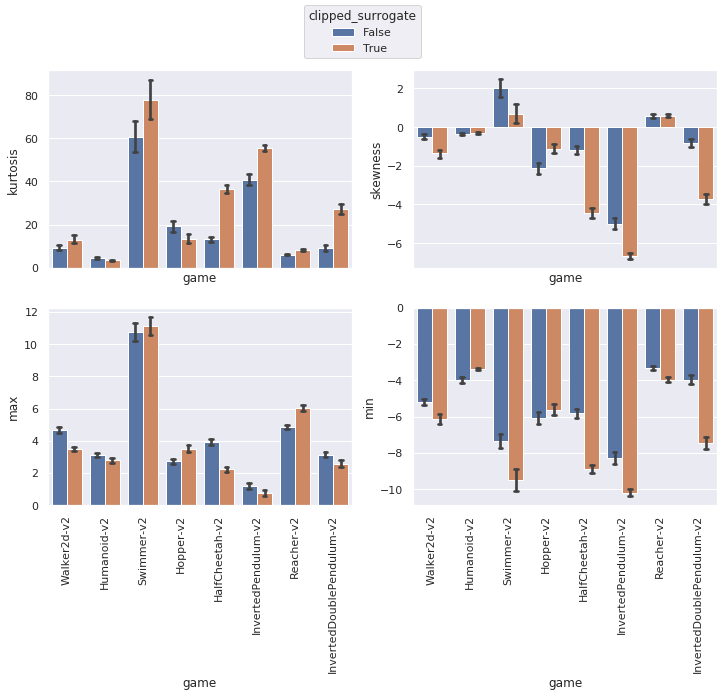

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex='all', sharey='none')
for j, metric in enumerate(nadv_metrics):
    b = sns.barplot(x='game', y=metric, hue='clipped_surrogate', data=nadv, ax=axes.flatten()[j], capsize=.1)
    for item in b.get_xticklabels():
        item.set_rotation(90)
    axes.flatten()[j].get_legend().remove()
handles, labels = axes[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=1, title='clipped_surrogate')
plt.show()

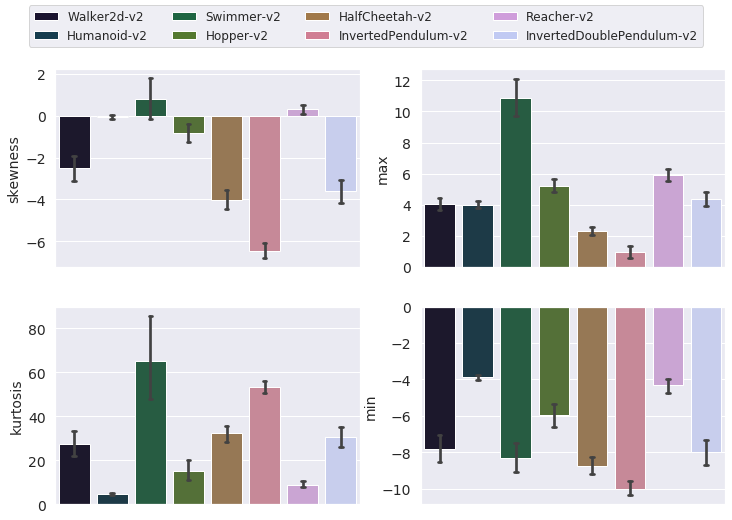

In [116]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex='all', sharey='none')
palette = sns.color_palette("cubehelix", 9)[:8]
for j, metric in enumerate(nadv_metrics):
    b = sns.barplot(x='game', y=metric,
                    data=nadv[(nadv.clipped_surrogate == True) & (nadv.kl_penalty == False) & (
                    nadv.norm_rewards == 'returns')],
                    ax=axes.flatten()[j], capsize=.1, palette=palette)
    axes.flatten()[j].set_xlabel('')
    axes.flatten()[j].set_ylabel(metric, fontsize=14)
    for item in b.get_xticklabels():
        item.set_rotation(50)
    #axes.flatten()[j].get_legend().remove()
#handles, labels = axes[-1][-1].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center', ncol=1, title='clipped_surrogate')

from matplotlib.patches import Patch
legend_elements = []
labels = [t.get_text() for t in axes[-1][-1].get_xticklabels()]
for i, label in enumerate(labels):
    legend_elements.append(Patch(facecolor=palette[i], label=label))

for ax in axes[1]:
    ax.set_xticklabels([])
    
for ax in axes.flatten():
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    
fig.legend(handles=legend_elements, loc='upper center', ncol=4, fontsize=12)

plt.show()

In [118]:
constraints_heldout['log_max_ratio'] = np.log(constraints_heldout['max_ratio'])
constraints_heldout['exp_kl'] = np.exp(constraints_heldout['avg_kl_new_to_old'])

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


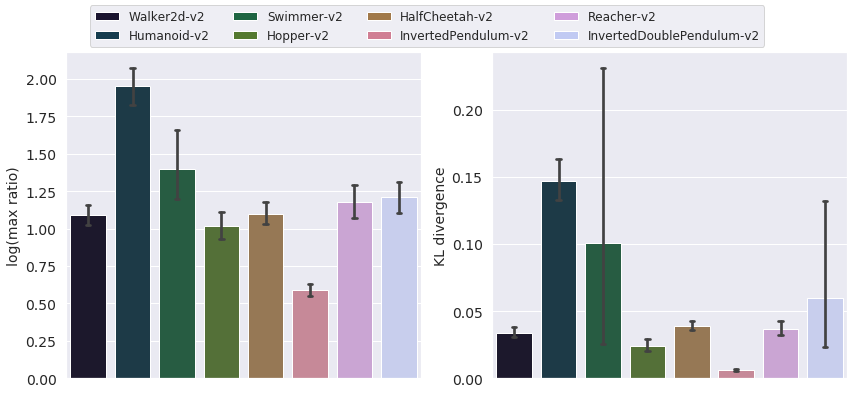

In [129]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex='all', sharey='none')
palette = sns.color_palette("cubehelix", 9)[:8]
for j, metric in enumerate(['log_max_ratio', 'avg_kl_new_to_old']):
    b = sns.barplot(x='game', y=metric,
                    data=constraints_heldout[(constraints_heldout.clipped_surrogate == True) & (
                        constraints_heldout.kl_penalty == False) & (constraints_heldout.norm_rewards == 'returns')],
                    ax=axes.flatten()[j], capsize=.1, palette=palette)
    axes.flatten()[j].set_xlabel('')
    axes.flatten()[j].set_ylabel(metric, fontsize=14)
    for item in b.get_xticklabels():
        item.set_rotation(50)
    #axes.flatten()[j].get_legend().remove()
#handles, labels = axes[-1][-1].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center', ncol=1, title='clipped_surrogate')

from matplotlib.patches import Patch
legend_elements = []
labels = [t.get_text() for t in axes[-1].get_xticklabels()]
for i, label in enumerate(labels):
    legend_elements.append(Patch(facecolor=palette[i], label=label))

for ax in axes:
    ax.set_xticklabels([])
    
for ax in axes.flatten():
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    
fig.legend(handles=legend_elements, loc='upper center', ncol=4, fontsize=12)

#axes[1].set_ylim([0, 1])
axes[0].set_ylabel('log(max ratio)')
axes[1].set_ylabel('KL divergence')

plt.show()

In [28]:
from scipy.stats.stats import pearsonr   
pearsonr(constraints.avg_kl_old_to_new.dropna(), constraints.avg_kl_new_to_old.dropna())

(0.9999265573492466, 0.0)

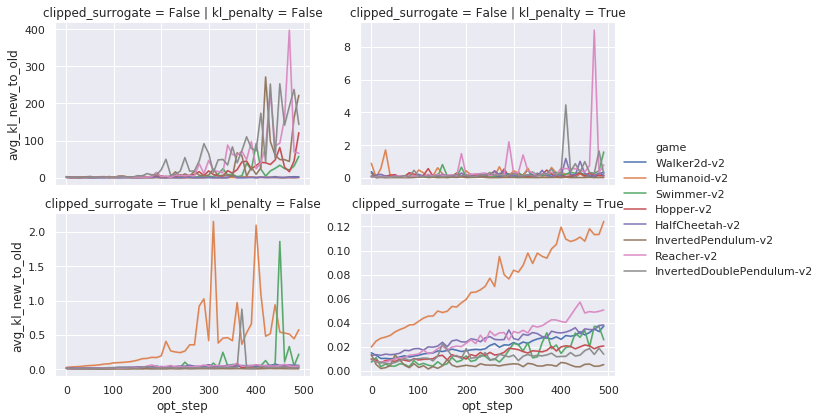

In [43]:
sns.relplot(x='opt_step', y='avg_kl_new_to_old', height=4, ci=False,
            data=constraints_heldout, kind='line', aspect=1.5,
            hue='game', row='clipped_surrogate', col='kl_penalty',
            facet_kws={'sharey': False, 'sharex': True})
plt.show()

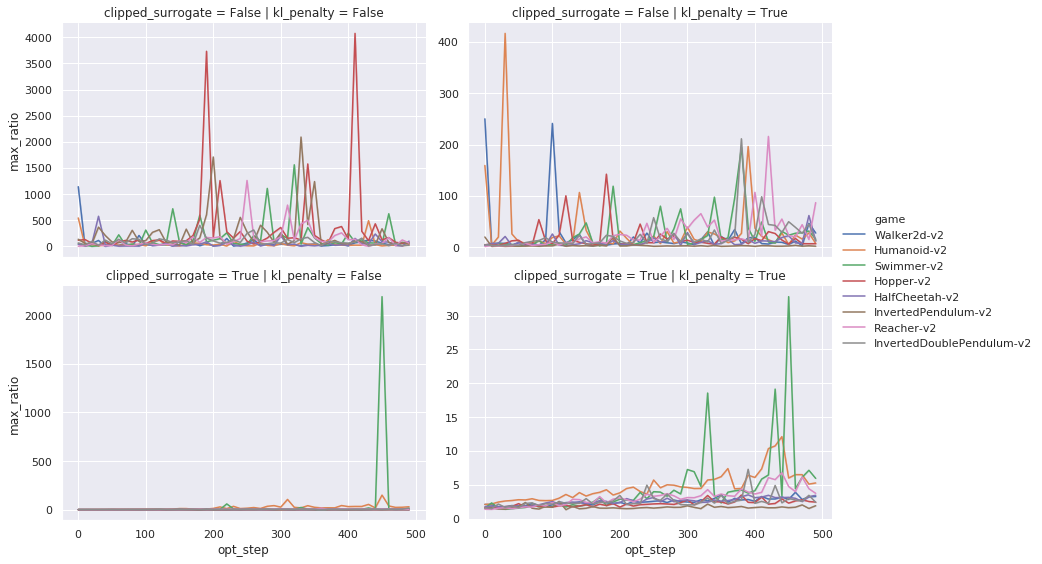

In [44]:
sns.relplot(x='opt_step', y='max_ratio', height=4, ci=False,
            data=constraints_heldout, kind='line', aspect=1.5,
            hue='game', row='clipped_surrogate', col='kl_penalty',
            facet_kws={'sharey': False, 'sharex': True})
plt.show()

In [10]:
nadv_and_constraints = nadv.merge(
    constraints_heldout[['exp_id', 'opt_step', 'max_ratio', 'avg_kl_new_to_old', 'avg_kl_old_to_new']],
    on=['exp_id', 'opt_step'])

In [51]:
nadv_and_constraints_game_agg = nadv_and_constraints.groupby('game').mean()

In [11]:
nadv_and_constraints['skewness_abs'] = np.abs(nadv_and_constraints['skewness'])
nadv_and_constraints['log_max_ratio'] = np.maximum(np.log(nadv_and_constraints['max_ratio']), 0)
nadv_and_constraints['log_kl'] = np.log(nadv_and_constraints['avg_kl_old_to_new'])
nadv_and_constraints['logZ_pred'] = np.log(1 + 0.3 ** 2 / 2 + 0.3 ** 3 * nadv_and_constraints[
    'skewness'] / 2 + 0.3 ** 4 * nadv_and_constraints['kurtosis'] / 4)

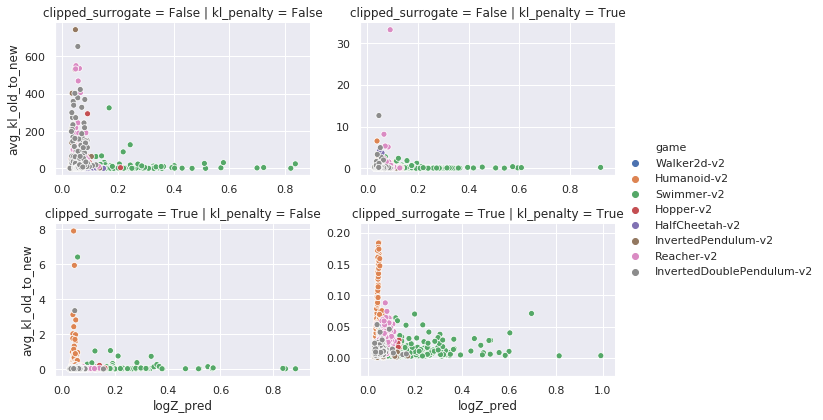

In [76]:
sns.relplot(x='logZ_pred', y='avg_kl_old_to_new', height=3, ci=False,
            data=nadv_and_constraints, kind='scatter', aspect=1.5,
            hue='game', row='clipped_surrogate', col='kl_penalty',
            facet_kws={'sharey': False, 'sharex': False})
plt.show()

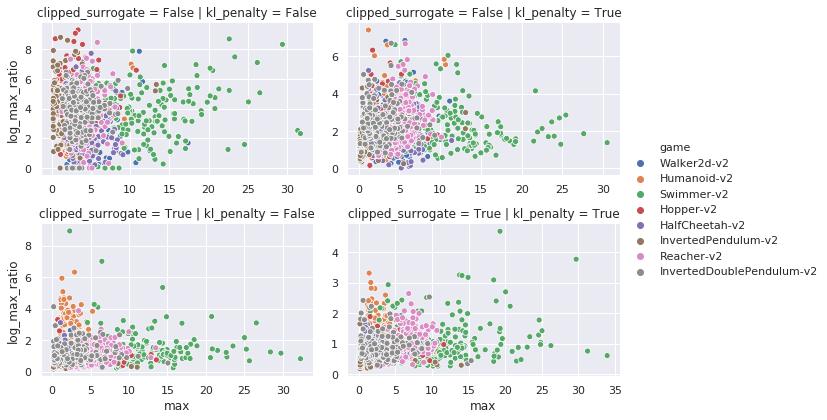

In [72]:
sns.relplot(x='max', y='log_max_ratio', height=3, ci=False,
            data=nadv_and_constraints, kind='scatter', aspect=1.5,
            hue='game', row='clipped_surrogate', col='kl_penalty',
            facet_kws={'sharey': False, 'sharex': False})
plt.show()

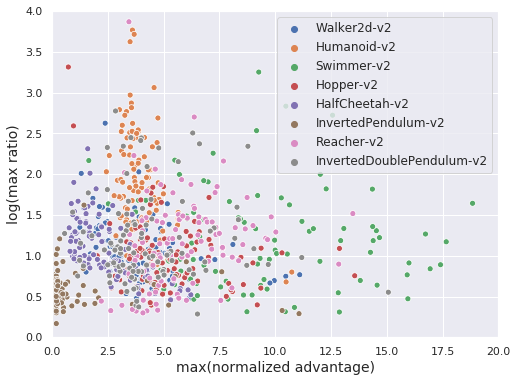

In [22]:
fig=plt.figure(figsize=(8,6))
ax = sns.scatterplot(x='max', y='log_max_ratio',
            data=nadv_and_constraints[(nadv_and_constraints.clipped_surrogate == True) & (
                        nadv_and_constraints.kl_penalty == False) & (
                        nadv_and_constraints.norm_rewards == 'returns')],
            hue='game')
ax.set_ylim([0, 4])
ax.set_xlim([0, 20])
ax.legend().remove()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:], loc='upper right', ncol=1, fontsize=12)
ax.set_xlabel('max(normalized advantage)',fontsize=14)
ax.set_ylabel('log(max ratio)', fontsize=14)
plt.show()

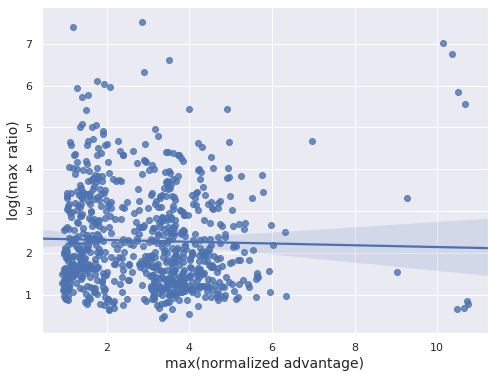

In [37]:
fig=plt.figure(figsize=(8,6))
#tmp = nadv_and_constraints[(nadv_and_constraints.clipped_surrogate == True) & (
#                        nadv_and_constraints.kl_penalty == False) & (
#                        nadv_and_constraints.norm_rewards == 'returns')]
tmp = nadv_and_constraints
tmp = tmp[tmp.game == 'Humanoid-v2']
ax = sns.regplot(x='max', y='log_max_ratio', data=tmp)
#ax.set_ylim([0, 4])
#ax.set_xlim([0, 20])
#ax.legend().remove()
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[1:], labels[1:], loc='upper right', ncol=1, fontsize=12)
ax.set_xlabel('max(normalized advantage)',fontsize=14)
ax.set_ylabel('log(max ratio)', fontsize=14)
plt.show()

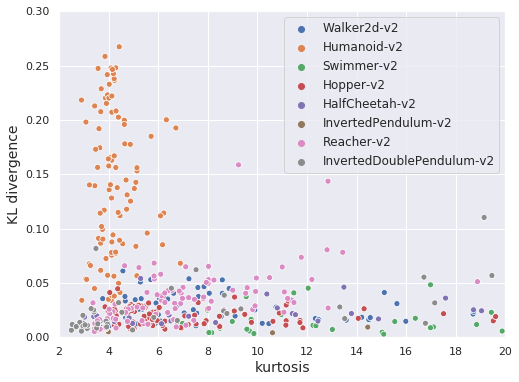

In [178]:
fig=plt.figure(figsize=(8,6))
ax = sns.scatterplot(x='kurtosis', y='avg_kl_new_to_old',
            data=nadv_and_constraints[(constraints_heldout.clipped_surrogate == True) & (
                        constraints_heldout.kl_penalty == False) & (
                        constraints_heldout.norm_rewards == 'returns')],
            hue='game')
ax.set_ylim([0, 0.3])
ax.set_xlim([2, 20])
ax.legend().remove()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:], loc='upper right', ncol=1, fontsize=12)
ax.set_xlabel('kurtosis',fontsize=14)
ax.set_ylabel('KL divergence', fontsize=14)
plt.show()

No handles with labels found to put in legend.


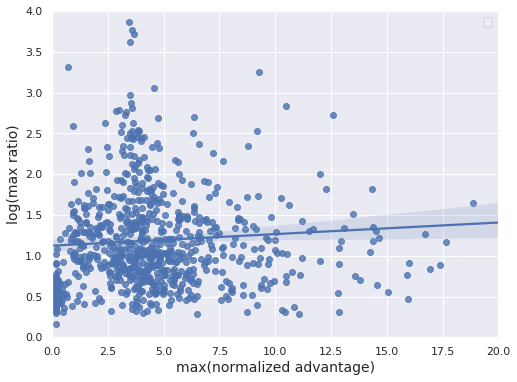

In [160]:
fig=plt.figure(figsize=(8,6))
ax = sns.regplot(x='max', y='log_max_ratio',
            data=nadv_and_constraints[(constraints_heldout.clipped_surrogate == True) & (
                        constraints_heldout.kl_penalty == False) & (
                        constraints_heldout.norm_rewards == 'returns')])
ax.set_ylim([0, 4])
ax.set_xlim([0, 20])
ax.legend().remove()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:], loc='upper right', ncol=1, fontsize=12)
ax.set_xlabel('max(normalized advantage)',fontsize=14)
ax.set_ylabel('log(max ratio)', fontsize=14)
plt.show()

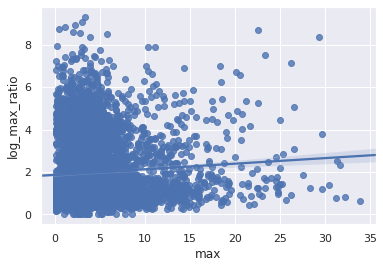

In [77]:
sns.regplot(x='max', y='log_max_ratio',
            data=nadv_and_constraints)
plt.show()

# How normalized advantage distribution changes over training

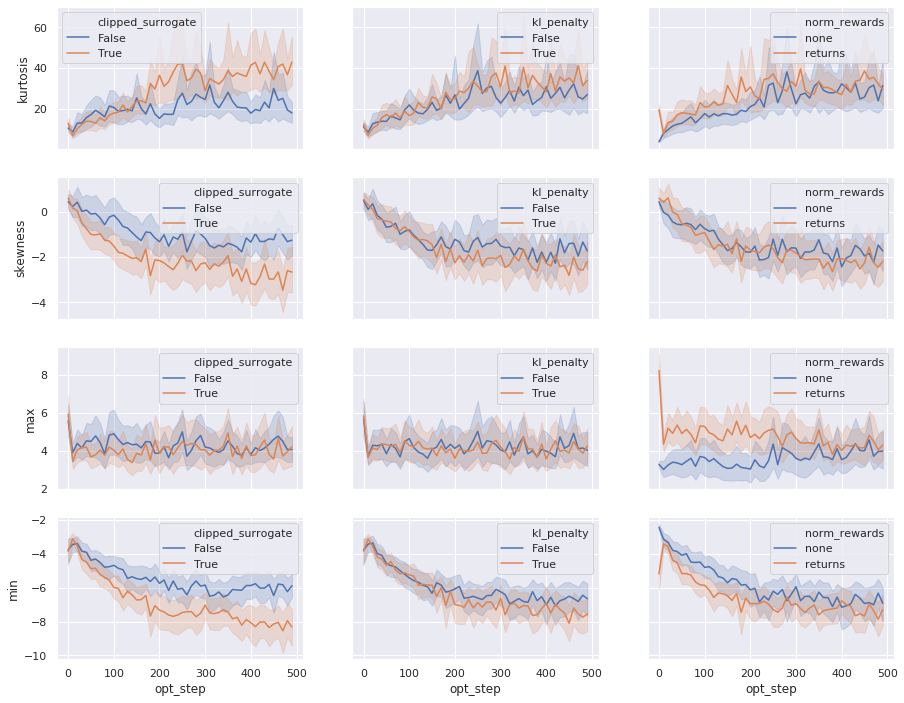

In [17]:
fig, axes = plt.subplots(4, 3, figsize=(15, 12), sharex='all', sharey='row')

for j, metric in enumerate(nadv_metrics):
    for i, cl_opt in enumerate(code_level_opts):
        sns.lineplot(x='opt_step', y=metric, hue=cl_opt, data=nadv, ax=axes[j][i])
plt.show()

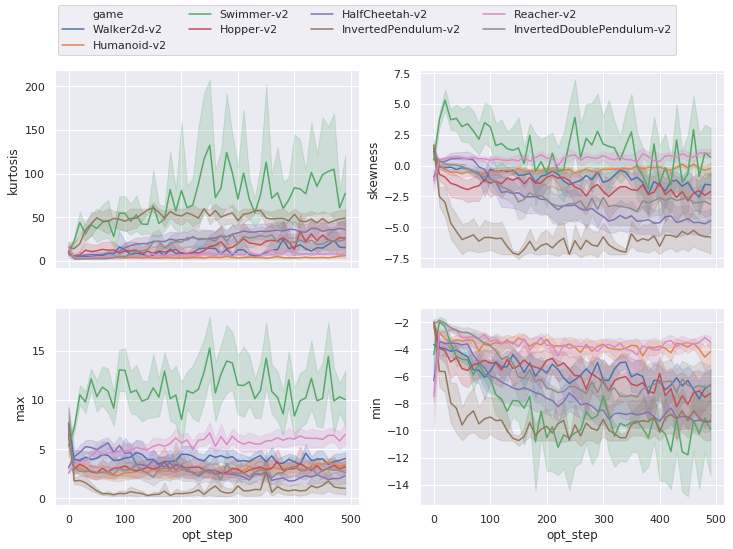

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex='all', sharey='none')
for j, metric in enumerate(nadv_metrics):
    sns.lineplot(x='opt_step', y=metric, hue='game', data=nadv, ax=axes.flatten()[j])
    axes.flatten()[j].get_legend().remove()
handles, labels = axes[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex='all', sharey='none')
for j, metric in enumerate(nadv_metrics):
    sns.lineplot(x='opt_step', y=metric, hue='game', data=nadv, ax=axes.flatten()[j])
    axes.flatten()[j].get_legend().remove()
handles, labels = axes[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)
plt.show()

In [22]:
constraints_heldout.head()

,avg_kl_old_to_new,avg_kl_new_to_old,max_ratio,opt_step,exp_id,game,clipped_surrogate,kl_penalty,norm_rewards
0,0.018215,0.017885,1.824150,0,af3d41ef-a73f-4588-a316-76ba67fc2d47,Walker2d-v2,True,False,none
1,0.015605,0.015332,1.764246,10,af3d41ef-a73f-4588-a316-76ba67fc2d47,Walker2d-v2,True,False,none
2,0.010508,0.010439,1.966247,20,af3d41ef-a73f-4588-a316-76ba67fc2d47,Walker2d-v2,True,False,none
3,0.013275,0.013173,1.951989,30,af3d41ef-a73f-4588-a316-76ba67fc2d47,Walker2d-v2,True,False,none
4,0.012776,0.012574,2.094458,40,af3d41ef-a73f-4588-a316-76ba67fc2d47,Walker2d-v2,True,False,none


# Rewards Scaling and Advantage Distribution

In [8]:
nadv

,opt_step,skewness,kurtosis,max,min,exp_id,game,clipped_surrogate,kl_penalty,norm_rewards
0,0,1.396284,7.295632,5.070531,-2.780076,af3d41ef-a73f-4588-a316-76ba67fc2d47,Walker2d-v2,True,False,none
1,10,-0.215966,2.886115,2.523295,-2.919073,af3d41ef-a73f-4588-a316-76ba67fc2d47,Walker2d-v2,True,False,none
2,20,-0.248265,3.514193,2.121987,-3.921864,af3d41ef-a73f-4588-a316-76ba67fc2d47,Walker2d-v2,True,False,none
3,30,-0.737380,4.190238,2.335028,-3.822209,af3d41ef-a73f-4588-a316-76ba67fc2d47,Walker2d-v2,True,False,none
4,40,-0.644851,4.251450,3.630068,-3.992990,af3d41ef-a73f-4588-a316-76ba67fc2d47,Walker2d-v2,True,False,none
...,...,...,...,...,...,...,...,...,...,...
6395,450,-0.871898,2.681578,1.346254,-3.369159,a5109e89-cf5c-4968-8991-1112d85c574b,InvertedDoublePendulum-v2,False,True,none
6396,460,-1.246723,3.547575,1.967995,-3.750054,a5109e89-cf5c-4968-8991-1112d85c574b,InvertedDoublePendulum-v2,False,True,none
6397,470,-0.360943,1.951902,1.805517,-2.672426,a5109e89-cf5c-4968-8991-1112d85c574b,InvertedDoublePendulum-v2,False,True,none
6398,480,-0.182527,2.073699,2.461027,-2.264763,a5109e89-cf5c-4968-8991-1112d85c574b,InvertedDoublePendulum-v2,False,True,none


# Plot mean rewards

In [ ]:
# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    for i, cl_opt in enumerate(code_level_opts):
        for b in code_level_opts[cl_opt]:
            filt = opt[(opt[cl_opt] == b) & (opt.game == g)]
            sns.lineplot(filt.opt_step, filt.mean_reward,
                         ax=ax.flatten()[j], label=f"{cl_opt}: {b}", legend=False)
        ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0][0].set_ylabel('Mean Reward')
ax[1][0].set_xlabel('Mean Reward')
for a in ax[1]:
    a.set_xlabel('# Iterations')
    
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')

plt.show()

# Plot cumulative distribution of max rewards

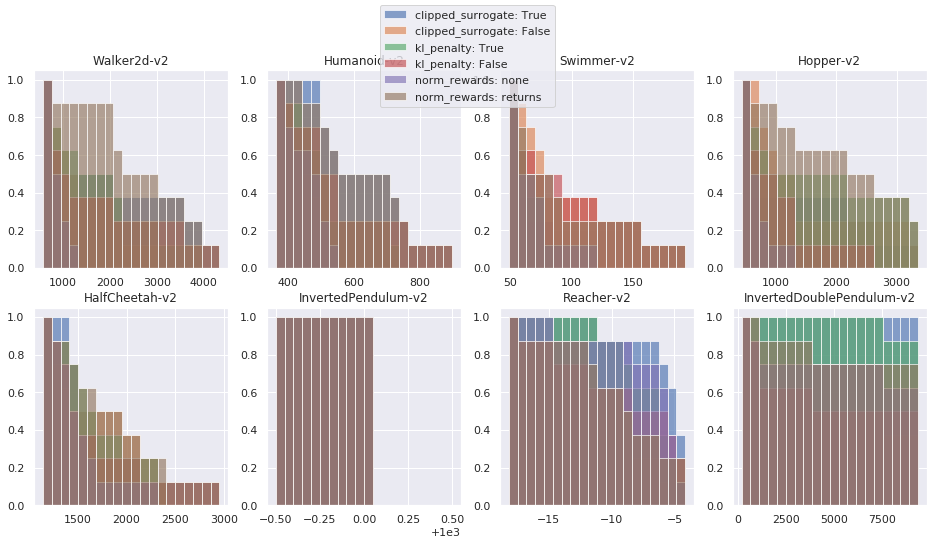

In [9]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            ax.flatten()[j].bar(bin_locs, hist, label=f"{cl_opt}: {b}",
                                **kwargs)
        ax.flatten()[j].set_title(g)
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

# Plot distribution of max rewards

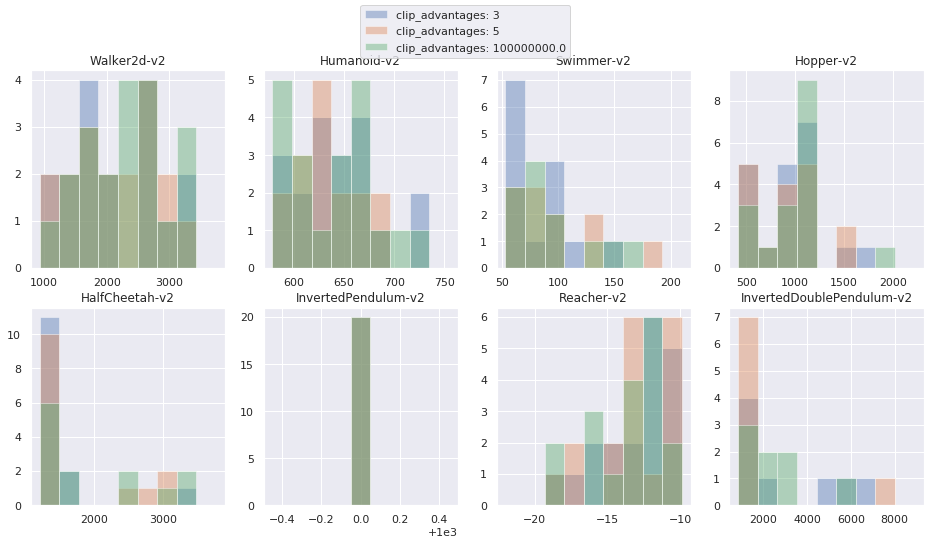

In [11]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), 10)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            #hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            #hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            sns.distplot(filt['mean_reward'].tolist(),
                         bins=bin_locs, label=f"{cl_opt}: {b}", ax=ax.flatten()[j], kde=False)
        ax.flatten()[j].set_title(g)
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

# Aggregate performance in normalized scores

In [11]:
max_and_min = max_rewards[['game', 'mean_reward']].groupby('game').max().rename(
    columns={'mean_reward': 'max_max_reward'})
max_and_min['min_max_reward'] = max_rewards[['game', 'mean_reward']].groupby('game').min()

In [12]:
ks = ['game'] + list(code_level_opts.keys())
grouped = max_rewards[ks + ['mean_reward']].groupby(ks).mean().reset_index().set_index(ks)
grouped = grouped.rename(columns={'mean_reward': 'mean_max_reward'})
grouped['stddev'] = max_rewards[ks + ['mean_reward']].groupby(ks).var().reset_index().set_index(ks).apply(np.sqrt)
grouped = grouped.reset_index()
grouped = grouped.reset_index().merge(max_and_min, on='game')
grouped = grouped.set_index(ks)
grouped['normalized_score'] = (grouped['mean_max_reward'] - grouped['min_max_reward']) / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped['normalized_stddev'] = grouped['stddev'] / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped = grouped.dropna()
grouped

index  \
game                      clipped_surrogate kl_penalty norm_rewards          
HalfCheetah-v2            False             False      none              0   
                                                       returns           1   
                                            True       none              2   
                                                       returns           3   
                          True              False      none              4   
                                                       returns           5   
                                            True       none              6   
                                                       returns           7   
Hopper-v2                 False             False      none              8   
                                                       returns           9   
                                            True       none             10   
                                                       returns          11   
                          True              False      none             12   
                                                       returns          13   
                                            True       none             14   
                                                       returns          15   
Humanoid-v2               False             False      none             16   
                                                       returns          17   
                                            True       none             18   
                                                       returns          19   
                          True              False      none             20   
                                                       returns          21   
                                            True       none             22   
                                                       returns          23   
InvertedDoublePendulum-v2 False             False      none             24   
                                                       returns          25   
                                            True       none             26   
                                                       returns          27   
                          True              False      none             28   
                                                       returns          29   
                                            True       none             30   
                                                       returns          31   
Reacher-v2                False             False      none             40   
                                                       returns          41   
                                            True       none             42   
                                                       returns          43   
                          True              False      none             44   
                                                       returns          45   
                                            True       none             46   
                                                       returns          47   
Swimmer-v2                False             False      none             48   
                                                       returns          49   
                                            True       none             50   
                                                       returns          51   
                          True              False      none             52   
                                                       returns          53   
                                            True       none             54   
                                                       returns          55   
Walker2d-v2               False             False      none             56   
                                                       returns          57   
             

In [19]:
ks = ['game'] + list(code_level_opts.keys())
tmp = max_rewards[ks + ['mean_reward']].merge(max_and_min, on='game')
tmp['normalized_score'] = (tmp['mean_reward'] - tmp['min_max_reward']) / (
    tmp['max_max_reward'] - tmp['min_max_reward'])
normalized_score = tmp[['game', 'norm_rewards', 'normalized_score']]
normalized_score['game'] = normalized_score['game'].apply(lambda s: s.strip('-v2'))

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


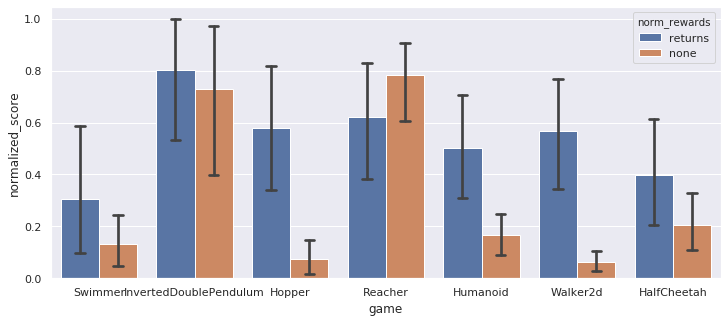

In [20]:
plt.figure(figsize=(12, 5))
sns.barplot(x="game", y="normalized_score", hue="norm_rewards",
            data=normalized_score.dropna().reset_index(), capsize=.1)

In [21]:
normalized_score.groupby('norm_rewards').describe()

normalized_score                                               \
                        count      mean       std  min       25%       50%   
norm_rewards                                                                 
none                     56.0  0.308441  0.356108  0.0  0.041647  0.154346   
returns                  56.0  0.538899  0.356343  0.0  0.237420  0.550632   

                                  
                   75%       max  
norm_rewards                      
none          0.519288  0.999985  
returns       0.923521  1.000000